In [1]:
import math
import torch

from matplotlib import pyplot as plt
%matplotlib inline

import os
import argparse
import re
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
from m3gpr.config import get_cfg_defaults_all
from m3gpr.load_data import Data_set
from m3gpr.models import singleGP_gpytorch,rf_sklearn,HierarchicalGPModel,ExactGPModel

In [3]:
cfg = get_cfg_defaults_all()
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
parser = argparse.ArgumentParser(description="Configure files")
parser.add_argument("--cfg", required=True, help="path to config file", type=str)
args = parser.parse_args(['--cfg', 'data/harpoon_dataset.yaml'])
cfg.merge_from_file(args.cfg)

cfg.freeze()
setup_data = Data_set(cfg, 1)

df_x, df_y_wide, df_y_long = setup_data.Load_data_set()
print(df_x.shape)
print(df_y_wide.shape)
print(df_y_long.shape)

ohe
(72, 10)
(24, 6)
(72, 2)


In [4]:
##Split the data into training and testing sets
if cfg.MODEL.SPLIT == 'by-task':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_wide, test_size=0.2, random_state=0)
elif cfg.MODEL.SPLIT == 'combine':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y_long, test_size=0.2, random_state=0)

In [5]:
if cfg.MODEL.X_SCALE == 'x-minmax':
    x_scaler = MinMaxScaler()
elif cfg.MODEL.X_SCALE == 'x-stand':
    x_scaler = StandardScaler

xct = ColumnTransformer([('x_scaler',x_scaler,df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

if cfg.MODEL.X_SCALE != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train)
        t_test_x = torch.Tensor(scaled_X_test)
else:
        t_train_x = torch.Tensor(df_X_train.to_numpy())
        t_test_x = torch.Tensor(df_X_test.to_numpy())


In [6]:
t_train_y = torch.Tensor(df_y_train.to_numpy())[:,0]
print(t_train_y.shape)

o_t_train_x = t_train_x
o_t_train_y = t_train_y
#t_train_x = t_train_x[o_t_train_x[:, -1].sort()[1]]
#t_train_y = t_train_y[o_t_train_x[:, -1].sort()[1]]

torch.Size([57])


In [7]:
import gpytorch

likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = HierarchicalGPModel(o_t_train_x, o_t_train_y, likelihood)
model = ExactGPModel(o_t_train_x, o_t_train_y, likelihood)

# Training the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(o_t_train_x)
    loss = -mll(output, o_t_train_y)
    loss.backward()
    optimizer.step()

initial covar_x.shape torch.Size([57, 57])
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.sha

In [ ]:
"""
mean_x = model.mean_module(t_test_x)
covar_x = model.kernels[0](t_test_x)

input_max = t_test_x.shape[1] - 1
extra_dims = range(input_max, input_max + len(model.kernels)-1)
slices = [index_to_slices(t_test_x[:,i]) for i in extra_dims]
ls_result = [[[covar_x[s,s] + k(t_test_x[s]) + covar_x[s, s] for s in slices_i] for slices_i in slices_k] for k, slices_k in zip(model.kernels[1:], slices)]
covar_x0 = ls_result[0][0][0]
covar_x1 = ls_result[0][1][0]
covar_x2 = ls_result[0][2][0]

covar_x_local = torch.block_diag(covar_x0.to_dense(),covar_x1.to_dense(),covar_x2.to_dense())
print(covar_x_local.shape)"
"""

torch.Size([15, 15])


In [8]:
o_t_test_x = t_test_x
#t_test_x = t_test_x[o_t_test_x[:, -1].sort()[1]]
print('t_test_x.shape',t_test_x.shape)
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output_test = model(o_t_test_x)

t_test_x.shape torch.Size([15, 10])
initial covar_x.shape torch.Size([57, 57])
initial covar_x.shape torch.Size([72, 72])


In [11]:
t_test_x[:,-1]

tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.])

In [ ]:
# Making predictions
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(t_train_x))

"""
# Plotting the results
import matplotlib.pyplot as plt
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(t_train_x[:,0].numpy(), t_train_y.numpy(), 'k*')
    ax.plot(t_test_x[:,0].numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(t_test_x[:,0].numpy(), 
                    observed_pred.mean.numpy() - 2 * observed_pred.variance.sqrt().numpy(),
                    observed_pred.mean.numpy() + 2 * observed_pred.variance.sqrt().numpy(),
                    alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()
"""
observed_pred.mean.numpy()

torch.Size([114, 114])
torch.Size([57, 57])


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


RuntimeError: The size of tensor a (114) must match the size of tensor b (57) at non-singleton dimension 1

In [13]:
import gpytorch
kernel_layer1 = gpytorch.kernels.RBFKernel()
kernel_layer2 = gpytorch.kernels.RBFKernel()

In [14]:
def index_to_slices(index):
    """
    take a numpy array of integers (index) and return a  nested list of slices such that the slices describe the start, stop points for each integer in the index.

    e.g.
    >>> index = np.asarray([0,0,0,1,1,1,2,2,2])
    returns
    >>> [[slice(0,3,None)],[slice(3,6,None)],[slice(6,9,None)]]

    or, a more complicated example
    >>> index = np.asarray([0,0,1,1,0,2,2,2,1,1])
    returns
    >>> [[slice(0,2,None),slice(4,5,None)],[slice(2,4,None),slice(8,10,None)],[slice(5,8,None)]]
    """
    if len(index) == 0:
        return []

    # contruct the return structure
    ind = np.asarray(index, dtype=int)
    ret = [[] for i in range(ind.max() + 1)]

    # find the switchpoints
    ind_ = np.hstack((ind, ind[0] + ind[-1] + 1))
    switchpoints = np.nonzero(ind_ - np.roll(ind_, +1))[0]

    [
        ret[ind_i].append(slice(*indexes_i))
        for ind_i, indexes_i in zip(
            ind[switchpoints[:-1]], zip(switchpoints, switchpoints[1:])
        )
    ]
    return ret

In [16]:
o_t_train_x = t_train_x
t_train_x = t_train_x[o_t_train_x[:, -1].sort()[1]]
t_train_y = t_train_y[o_t_train_x[:, -1].sort()[1]]
print(t_train_x[:,-1])
print(o_t_train_x[:,-1])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2.])
tensor([2., 2., 2., 1., 0., 2., 2., 0., 1., 0., 0., 2., 1., 0., 1., 2., 2., 2.,
        1., 0., 2., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
        0., 2., 1., 2., 1., 1., 0., 2., 0., 2., 1., 0., 0., 1., 0., 0., 2., 2.,
        2., 1., 1.])


In [29]:
kernels=[kernel_layer1, kernel_layer2]
X = t_test_x
input_max = X.shape[1] - 1
extra_dims = range(input_max, input_max + len(kernels)-1)
slices = [index_to_slices(X[:,i]) for i in extra_dims]
slices[0]

[[slice(0, 2, None)], [slice(2, 10, None)], [slice(10, 15, None)]]

In [ ]:
K = kernels[0](t_train_x).to_dense()
#X = t_train_x
ls_result = [[[np.add(K[s,s].detach().numpy(), k(X[s], None).to_dense().detach().numpy(), K[s, s].detach().numpy()) for s in slices_i] for slices_i in slices_k] for k, slices_k in zip(kernels[1:], slices)]
ls_result[0][2][0].shape

#ls_result = [[np.add(K[s,s].detach().numpy(), k(X[s], None).to_dense().detach().numpy(), K[s, s].detach().numpy()) for s in slices_k] for k, slices_k in zip(kernels[1:], slices[0])]


(19, 19)

In [30]:

K = kernels[0](X )
K_mat = kernels[0](X).to_dense()
ls_result2 = [[[K[s,s] + k(X[s]) + K[s, s] for s in slices_i] for slices_i in slices_k] for k, slices_k in zip(kernels[1:], slices)]

In [31]:
#ls_result[0][2][0]
mean_K = gpytorch.means.ConstantMean()
mean_x = mean_K(X)
covar_x = kernels[0](X)
covar_x0 = ls_result2[0][0][0]
covar_x1 = ls_result2[0][1][0]
covar_x2 = ls_result2[0][2][0]
print(covar_x.shape)
print(covar_x0.shape)
print(covar_x1.shape)
print(covar_x2.shape)

covar_x_local = torch.block_diag(covar_x0.to_dense(),covar_x1.to_dense(),covar_x2.to_dense())
covar_x_total = covar_x.to_dense() + covar_x_local
covar_x_total.shape

torch.Size([15, 15])
torch.Size([2, 2])
torch.Size([8, 8])
torch.Size([5, 5])


torch.Size([15, 15])

In [106]:
result = gpytorch.distributions.MultivariateNormal(mean_x, covar_x_total)
result.covariance_matrix

tensor([[4.0000e+00, 5.9721e-02, 4.2249e-01,  ..., 1.6440e-03, 1.6440e-03,
         2.3239e-04],
        [5.9721e-02, 4.0000e+00, 5.9721e-02,  ..., 2.3239e-04, 2.3239e-04,
         2.4227e-04],
        [4.2249e-01, 5.9721e-02, 4.0000e+00,  ..., 1.9419e-03, 1.5565e-02,
         2.3239e-04],
        ...,
        [1.6440e-03, 2.3239e-04, 1.9419e-03,  ..., 4.0000e+00, 4.9904e-01,
         5.9721e-02],
        [1.6440e-03, 2.3239e-04, 1.5565e-02,  ..., 4.9904e-01, 4.0000e+00,
         5.9721e-02],
        [2.3239e-04, 2.4227e-04, 2.3239e-04,  ..., 5.9721e-02, 5.9721e-02,
         4.0000e+00]], grad_fn=<ExpandBackward0>)

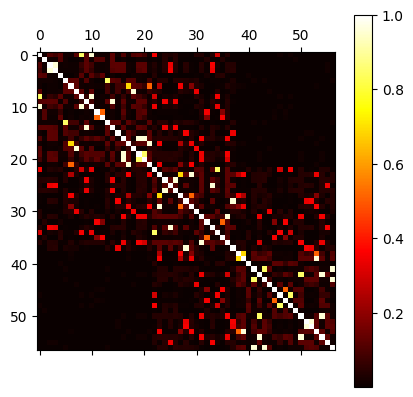

In [61]:
plt.matshow(covar_x.to_dense().detach().numpy(), cmap=plt.cm.hot); plt.colorbar()

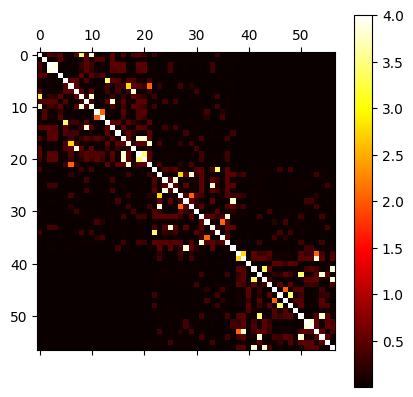

In [101]:
plt.matshow(covar_x_total.detach().numpy(), cmap=plt.cm.hot); plt.colorbar()

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_14634/430443970.py:171: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_14634/430443970.py:174: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


KeyError: 'lower'

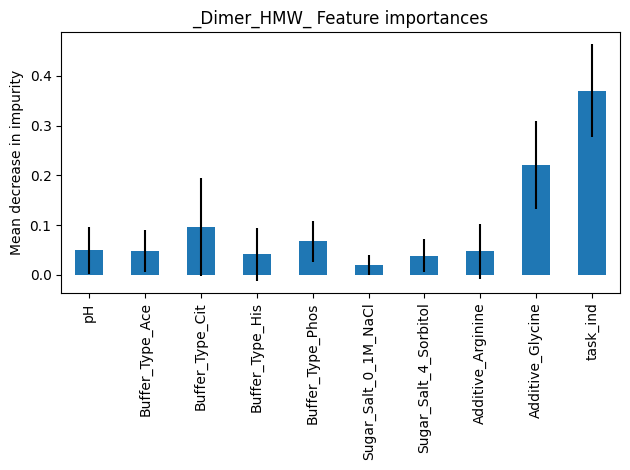

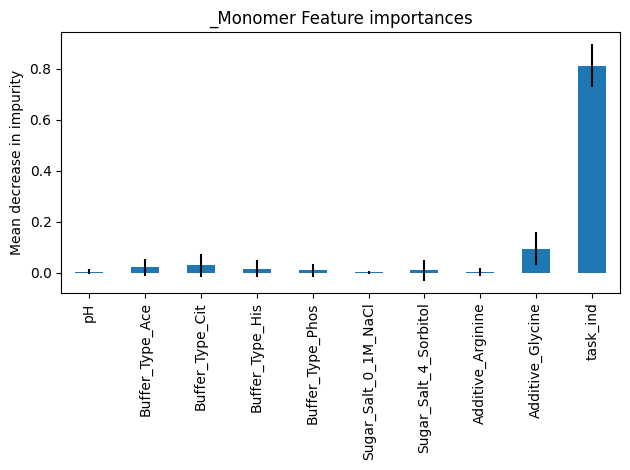

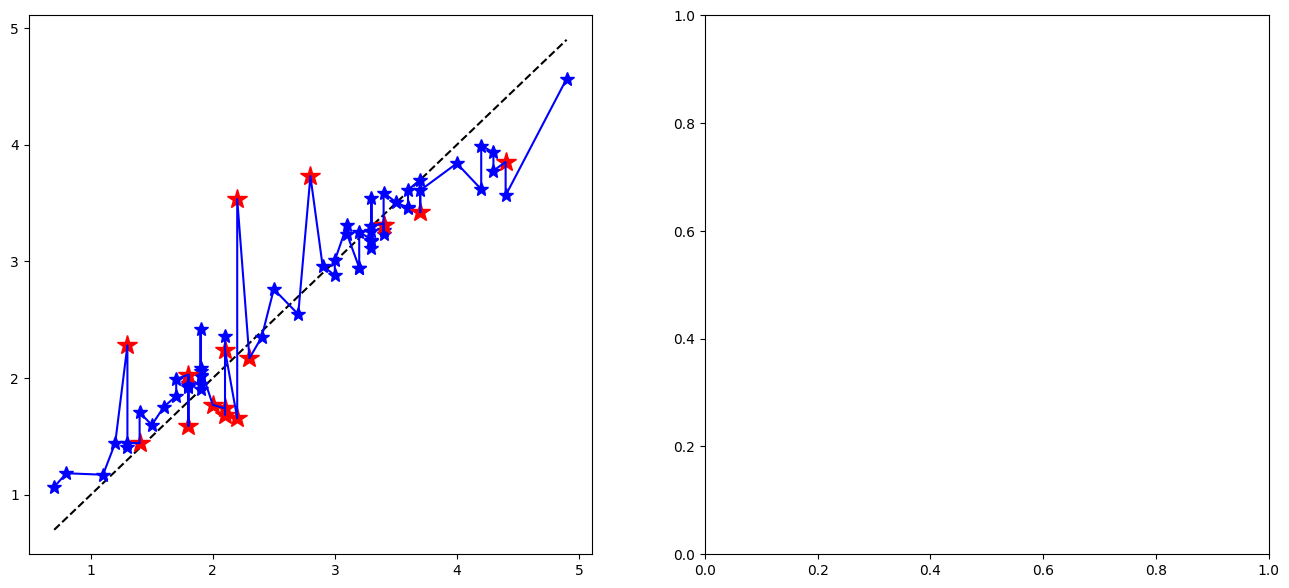

In [ ]:
#singleGP and rf


is_plot_imp = True #for random forest
uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target = df_y_long.columns
cols_target_plot = df_y_train.columns
figPath = setup_data.output_path

plot_axis_lb = df_y_long[cols_target].min(axis = 0) - 0.4* df_y_long[cols_target].std(axis = 0)
plot_axis_ub = df_y_long[cols_target].max(axis = 0) + 0.4* df_y_long[cols_target].std(axis = 0)

num_outputs = cfg.DATA.NUM_OUTPUTS
if cfg.MODEL.SPLIT == 'by-task':
  num_tasks = cfg.DATA.NUM_TASKS
else:
  num_tasks = 1
num_iters = cfg.MODEL.NUM_TRAIN_ITERS

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

ls_df_comp_sorted = []
ls_df_train_comp = []
ls_df_test_comp = []
# Start Training Process

for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_plot[a]

    if cfg.MODEL.MODEL_NAME == 'rf':
      y_train = df_y_train[tmp_col_y].to_numpy()
      y_true = df_y_test[tmp_col_y].to_numpy()
      mean_train_pred, mean_test_pred, rf_grid = rf_sklearn(scaled_X_train,y_train,scaled_X_test,
                                                       cv_option = 'shuffle-split')
      
      
      y_pred = mean_test_pred
      best_rf = rf_grid.best_estimator_
      importances=best_rf.feature_importances_
      std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
      cols_feature_new = df_x.columns
      forest_importances = pd.Series(importances, index=cols_feature_new)
      
      if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))


    elif cfg.MODEL.MODEL_NAME == 'singleGP':
      if cfg.MODEL.Y_SCALE == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      elif cfg.MODEL.Y_SCALE == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      elif cfg.MODEL.Y_SCALE == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train[[tmp_col_y]])
      else:
        scaled_y_train = df_y_train[[tmp_col_y]].to_numpy()

      t_train_y = torch.Tensor(scaled_y_train).flatten()
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = singleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = num_iters)
    

      t_test_y = torch.Tensor(df_y_test.to_numpy())[:,a]
      arr_train_x = t_train_x.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      if cfg.MODEL.Y_SCALE=='no-y-scale':
        arr_train_y = t_train_y.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(t_train_y.reshape(-1,1))
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    if cfg.MODEL.MODEL_NAME != 'rf':
      df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
      df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    if cfg.MODEL.MODEL_NAME != 'rf':
      df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
      df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    ls_df_train_comp.append(df_train_comp)
    ls_df_test_comp.append(df_test_comp)
    ls_df_comp_sorted.append(df_comp_sorted)
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    if cfg.MODEL.MODEL_NAME != 'rf':
      arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
      arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
      arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    if cfg.MODEL.MODEL_NAME != 'rf':
      arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
      arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
      arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)

#Initialize parity plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_plot[a]

    df_train_comp = ls_df_train_comp[a]
    df_test_comp = ls_df_test_comp[a]
    df_comp_sorted = ls_df_comp_sorted[a]

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      if cfg.MODEL.MODEL_NAME != 'rf':
        yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
        yerr = yerr.values.tolist()
        yerr_train = df_train_comp['pred'] - df_train_comp['lower']
        yerr_train = yerr_train.values.tolist()
        yerr_test = df_test_comp['pred'] - df_test_comp['lower']
        yerr_test = yerr_test.values.tolist()
        y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
        y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    
    if cfg.MODEL.MODEL_NAME == 'rf':
      y_axes[a].legend(['parity','train','test','GP Mean'])
    else:
      y_axes[a].legend(['Parity','Train','Test','GP Mean','GP Train Confidence','GP Test Confidence'])
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_plot, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_plot, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')